# Explorin Assylum Seeking data

Data found in The UN Refugee Agency [https://popstats.unhcr.org/refugee-statistics/download/]

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

## Moving in South Sudan

In [151]:
moving_in = pd.read_csv("data/moving_in.csv", on_bad_lines='skip')

# Removing Internal Displacements
moving_in = moving_in.drop(moving_in[moving_in["Country of origin (ISO)"] == "SSD"].index)

# Dropping redundant columns
moving_in = moving_in.drop(["Country of asylum (ISO)", "Country of asylum", "IDPs of concern to UNHCR", "Host Community", "Other people in need of international protection"], axis=1)

In [153]:
# Adding sum of all refugee like population
moving_in["Total"] = moving_in[["Refugees under UNHCR\'s mandate", "Asylum-seekers", "Stateless persons", "Others of concern"]].sum(axis=1)


In [154]:
moving_in.head()

,Year,Country of origin,Country of origin (ISO),Refugees under UNHCR's mandate,Asylum-seekers,Stateless persons,Others of concern,Total
0,2011,Central African Rep.,CAF,1025,0,0,0,1025
1,2011,Dem. Rep. of the Congo,COD,22186,0,0,0,22186
2,2011,Ethiopia,ETH,4967,85,0,0,5052
4,2011,Sudan,SDN,76845,5,0,0,76850
5,2012,Central African Rep.,CAF,1560,5,0,0,1565


### Most common countries to take refuge in South Sudan

In [155]:
moving_in["Country of origin"].value_counts()

Country of origin
Central African Rep.      12
Dem. Rep. of the Congo    12
Ethiopia                  12
Sudan                     12
Eritrea                   11
Somalia                    9
Burundi                    8
Cameroon                   4
Stateless                  3
Rwanda                     2
Congo                      1
Kenya                      1
Syrian Arab Rep.           1
Uganda                     1
Name: count, dtype: int64

### Visualisations

Added a linear regression trend line to the chart but idk if this comes off as redundant since the trend is pretty obvious

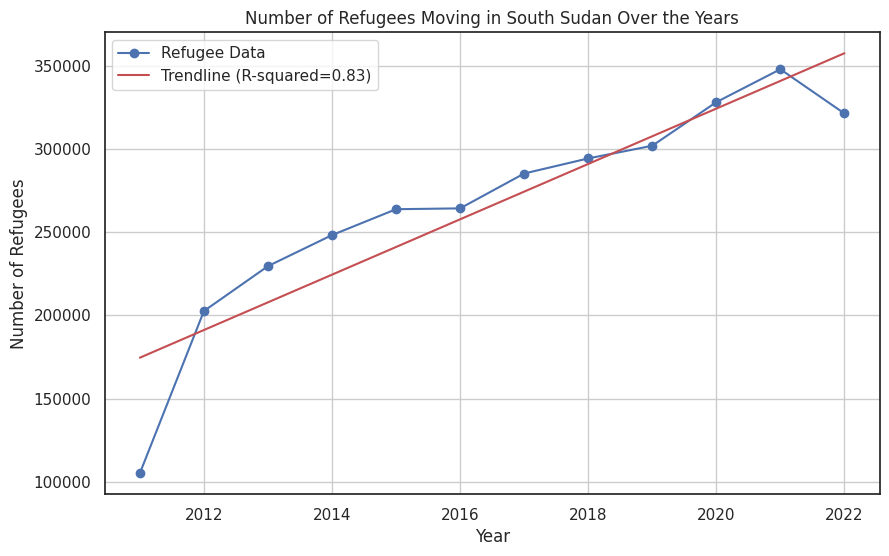

In [156]:
# Group and sum the data by year
df_grouped = moving_in.groupby('Year')[['Refugees under UNHCR\'s mandate', 'Asylum-seekers', 'Stateless persons', 'Others of concern', 'Total']].sum().reset_index()

# Creating a line chart
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Year'], df_grouped['Total'], marker='o', linestyle='-', label='Refugee Data')
plt.title('Number of Refugees Moving in South Sudan Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Refugees')
plt.grid(True)

# Fitting a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(df_grouped['Year'], df_grouped['Total'])

# Create a trendline using the regression model
trendline = intercept + slope * df_grouped['Year']

# Add the trendline to the chart as a red line
plt.plot(df_grouped['Year'], trendline, 'r', label=f'Trendline (R-squared={r_value**2:.2f})')

# Add a legend to the chart
plt.legend()

# Show the plot
plt.show()

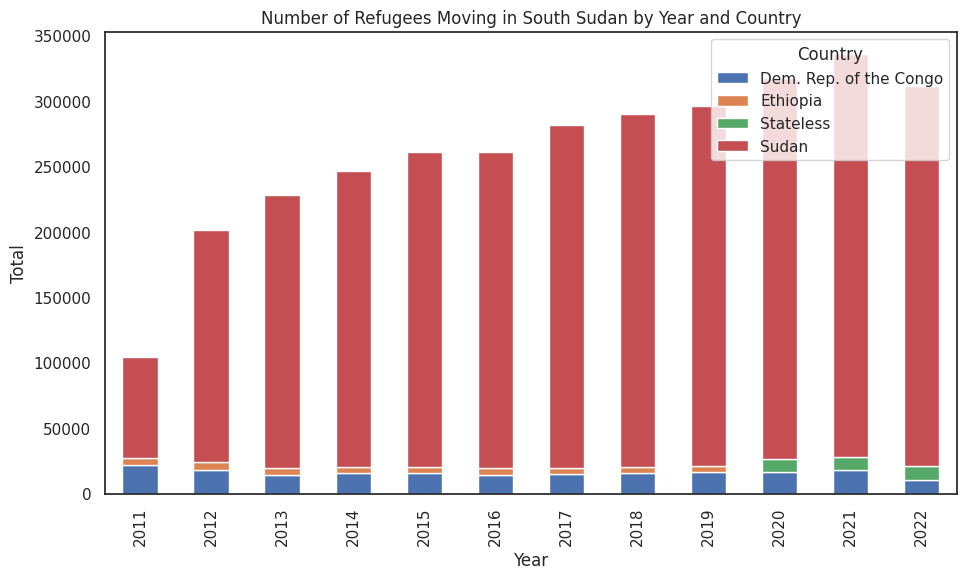

In [157]:
# Group and rank countries by year
moving_in['Rank'] = moving_in.groupby('Year')['Total'].rank(ascending=False)

# Filter for the top 3 countries
df_top3 = moving_in[moving_in['Rank'] <= 3]

# Pivot the data to create separate columns for each country
pivot_df = df_top3.pivot(index='Year', columns='Country of origin', values='Total')

# Create the bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(11, 6))
plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Number of Refugees Moving in South Sudan by Year and Country')
plt.legend(title='Country', loc='upper right')
plt.show()

In [158]:
df_grouped.head()

,Year,Refugees under UNHCR's mandate,Asylum-seekers,Stateless persons,Others of concern,Total
0,2011,105023,90,0,0,105113
1,2012,202581,32,0,0,202613
2,2013,229587,36,0,0,229623
3,2014,248152,128,0,0,248280
4,2015,263012,835,0,0,263847


In [ ]:
# Iterate through each year and create a donut chart
for year in df_grouped['Year']:
    year_data = df_grouped[df_grouped['Year'] == year].iloc[:, 1:-1]  # Exclude the "Total" column current year
    labels = year_data.columns
    sizes = year_data.values[0]

    # Create a donut chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), pctdistance=0.85)

    # Create a legend with labels
    ax.legend(wedges, labels, title="Asylum Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Draw a circle in the center to make it a donut chart
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Asylum Seekers Moving in SS by Kind - {year}')
    plt.show()

### Aggregating country wide data

In [178]:
ipc = pd.read_csv("data/generalised_ipc.csv")
ipc_country = ipc

ipc_country = ipc_country.drop(ipc_country.columns[0], axis=1)

# Filter for the years 2011 to 2020
years_to_include = list(range(2011, 2021))
ipc_country = ipc_country[ipc_country['year'].isin(years_to_include)]

# List of numeric columns
numeric_columns = [col for col in ipc_country.columns if pd.api.types.is_numeric_dtype(ipc_country[col])]

# Columns to remove
to_remove = ["year", "district_code", "centx", "centy", "month", "area", "pop", "cropland_pct", "date", "administrative_region", "quarters", "normalized_population", "weighted_ipc_pop", "pop_density", "weighted_ipc_density", "country"]

# Remove specified columns from numeric_columns
numeric_columns = [col for col in numeric_columns if col not in to_remove]

# Define a dictionary of aggregation functions
agg_funcs = {
    "ipc": "median",
    "ha": "sum",
    "count_violence": "sum",
    "sum_fatalities": "sum",
    "total_region_pop": "sum",
    "ndvi_mean": "median",
    "ndvi_anom": "median",
    "rain_mean": "median",
    "rain_anom": "median",
    "et_mean": "median",
    "et_anom": "median",
    "food_price_idx": "median",
    "ruggedness_mean": "median",
    "pasture_pct": "median",
    "generalized_ipc_pop": "median",
    "generalized_ipc_density": "median"
}

# Group and aggregate the columns
ipc_country = ipc_country.groupby(['year'])[numeric_columns].agg(agg_funcs).reset_index()

# Dropping columns "cropland_pct", "ruggedness_mean", "pasture_pct" bc they stay the same through the years
ipc_country = ipc_country.drop("pasture_pct", axis=1)

Calculating country population using total_region_pop

In [179]:
# Filtering relevant rows and columns from original ipc df
country_pop = ipc[["year", "total_region_pop"]]
years_to_include = list(range(2011, 2021))
country_pop = country_pop[country_pop['year'].isin(years_to_include)]

# Removing duplicated entries (since original df is per district)
duplicates = country_pop.duplicated(subset=['year', 'total_region_pop'], keep='first')

# Remove duplicate rows
country_pop = country_pop[~duplicates]

# Group and aggregate the columns
country_pop = country_pop.groupby('year').agg({"total_region_pop": "sum"}).reset_index()

In [180]:
# Adding country_pop column to ipc_country df
ipc_country = ipc_country.merge(country_pop, on=["year"])

# Changing name of column for better comprehension
ipc_country = ipc_country.rename({"total_region_pop_y": "country_pop"})

In [181]:
ipc_country.head()

,year,ipc,ha,count_violence,sum_fatalities,total_region_pop_x,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,food_price_idx,ruggedness_mean,generalized_ipc_pop,generalized_ipc_density,total_region_pop_y
0,2011,1.0,0.0,47,850,1.105003e+09,0.533569,100.557050,13.627400,-0.000542,14.935230,0.577368,1.366350,15014.3,1.586476,1.488962,10565486.0
1,2012,2.0,18.0,63,2833,1.151821e+09,0.550520,99.078385,13.214850,0.177425,17.821395,1.373149,2.015065,15014.3,1.952897,1.680615,11023274.0
2,2013,2.0,15.0,106,813,1.198641e+09,0.563453,102.366050,11.316705,-0.036695,14.238310,0.279024,2.069135,15014.3,1.479096,1.443426,11481064.0
3,2014,2.0,10.0,416,3708,1.245459e+09,0.600740,105.118400,16.154325,0.127691,17.858800,3.310333,2.209709,15014.3,2.000000,2.000000,11938851.0
4,2015,2.0,31.0,265,1494,1.292278e+09,0.565841,103.703000,15.131285,-0.049978,13.247315,0.614845,2.842725,15014.3,2.171017,2.195056,12396639.0


### Correlation between refugees moving in SS and food crisis factors

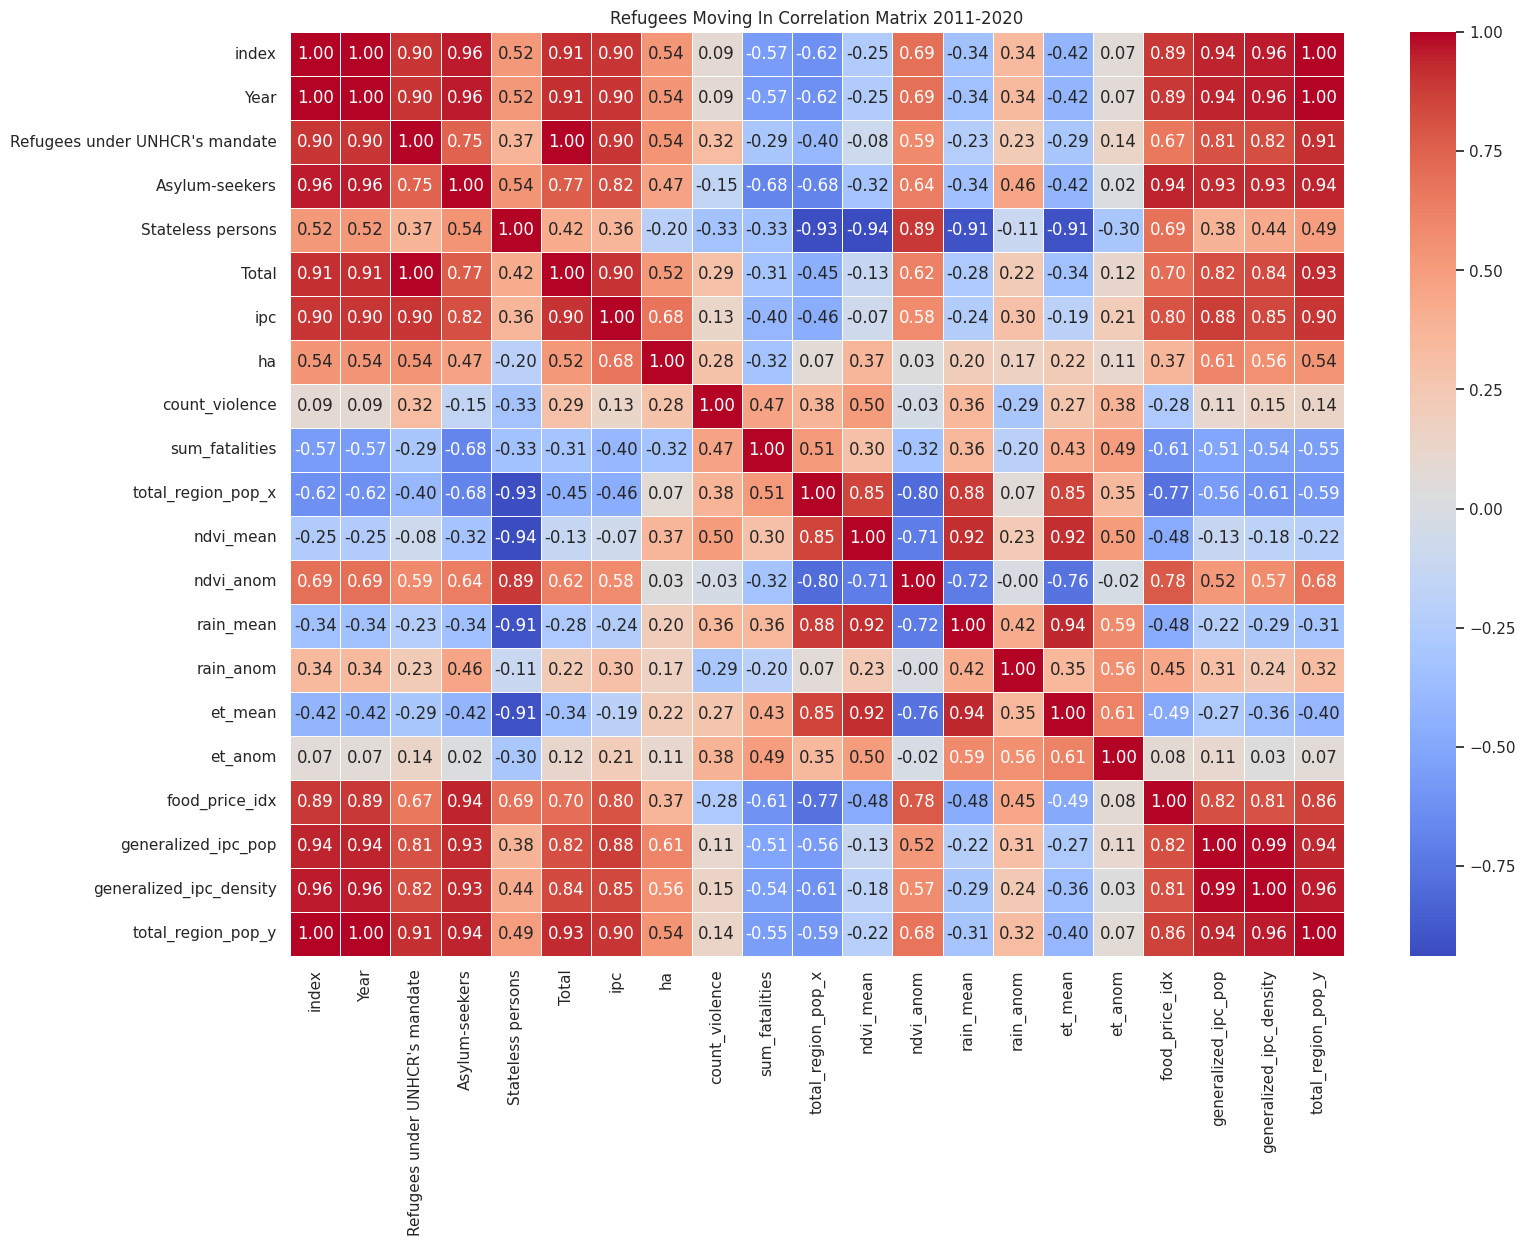

In [195]:
# renaming column and resetting index
ipc_country = ipc_country.rename(columns={"year": "Year"})
df_grouped.reset_index(inplace=True)

# Removing constant columns
df_grouped = df_grouped.drop("Others of concern", axis=1)
ipc_country = ipc_country.drop("ruggedness_mean", axis=1)

# Filter for the years 2011 to 2020
years_to_include = list(range(2011, 2021))
df_grouped = df_grouped[df_grouped['Year'].isin(years_to_include)]

merged_movein = pd.merge(df_grouped, ipc_country, on='Year')

# Calculate the correlation matrix
movein_corr = merged_movein.corr()

sns.set(style="white")

# # A function to plot the correlation matrix
def plot_correlation_matrix(corr_matrix, title):
    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(17, 12))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f")
    plt.title(title)
    plt.show()

plot_correlation_matrix(movein_corr, "Refugees Moving In Correlation Matrix 2011-2020")

## Moving out South Sudan

In [203]:
moving_out = pd.read_csv("data/moving_out.csv", on_bad_lines='skip')

# Removing Internal displacements
moving_out = moving_out.drop(moving_out[moving_out["Country of asylum (ISO)"] == "SSD"].index)

# Dropping redundant columns
moving_out = moving_out.drop(["Country of origin (ISO)", "Country of origin", "IDPs of concern to UNHCR", "Host Community", "Other people in need of international protection"], axis=1)

# Adding sum of all refugee like population
moving_out["Total"] = moving_out[["Refugees under UNHCR\'s mandate", "Asylum-seekers", "Stateless persons", "Others of concern"]].sum(axis=1)

moving_out.head()

,Year,Country of asylum,Country of asylum (ISO),Refugees under UNHCR's mandate,Asylum-seekers,Stateless persons,Others of concern,Total
0,2011,Germany,DEU,0,5,0,0,5
2,2012,Egypt,EGY,178,764,0,0,942
3,2012,Eritrea,ERI,25,0,0,0,25
4,2012,Ethiopia,ETH,58715,21,0,0,58736
5,2012,Germany,DEU,6,20,0,0,26


In [204]:
moving_out["Country of asylum"].value_counts()

Country of asylum
Germany                     12
Kenya                       11
United States of America    11
Uganda                      11
Syrian Arab Rep.            11
                            ..
Burundi                      1
Cote d'Ivoire                1
Russian Federation           1
Hungary                      1
Lithuania                    1
Name: count, Length: 66, dtype: int64

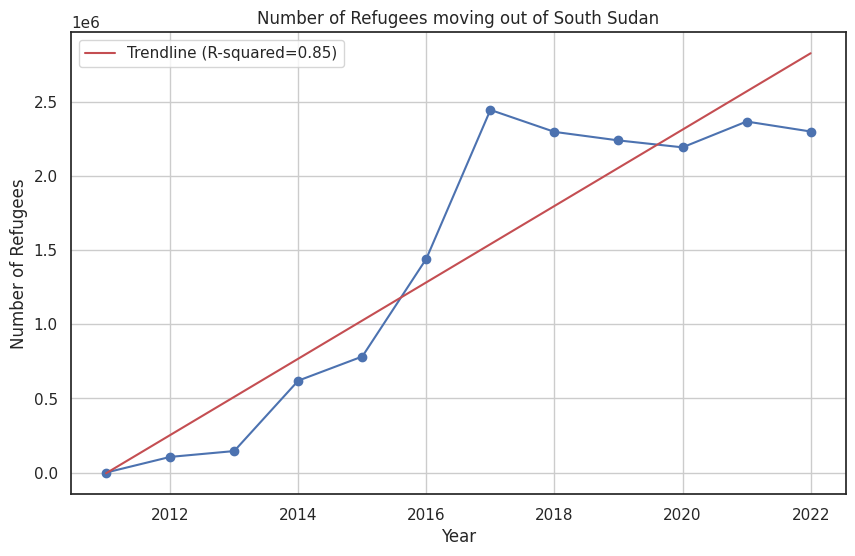

In [205]:
# Group and sum the data by year
df_grouped = moving_out.groupby('Year')[['Refugees under UNHCR\'s mandate', 'Asylum-seekers', 'Stateless persons', 'Others of concern', 'Total']].sum().reset_index()

# Create a line chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df_grouped['Year'], df_grouped['Total'], marker='o', linestyle='-')
plt.title('Number of Refugees moving out of South Sudan')
plt.xlabel('Year')
plt.ylabel('Number of Refugees')
plt.grid(True)

# Fitting a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(df_grouped['Year'], df_grouped['Total'])

# Create a trendline using the regression model
trendline = intercept + slope * df_grouped['Year']

# Add the trendline to the chart as a red line
plt.plot(df_grouped['Year'], trendline, 'r', label=f'Trendline (R-squared={r_value**2:.2f})')

# Add a legend to the chart
plt.legend()

# Show the plot
plt.show()

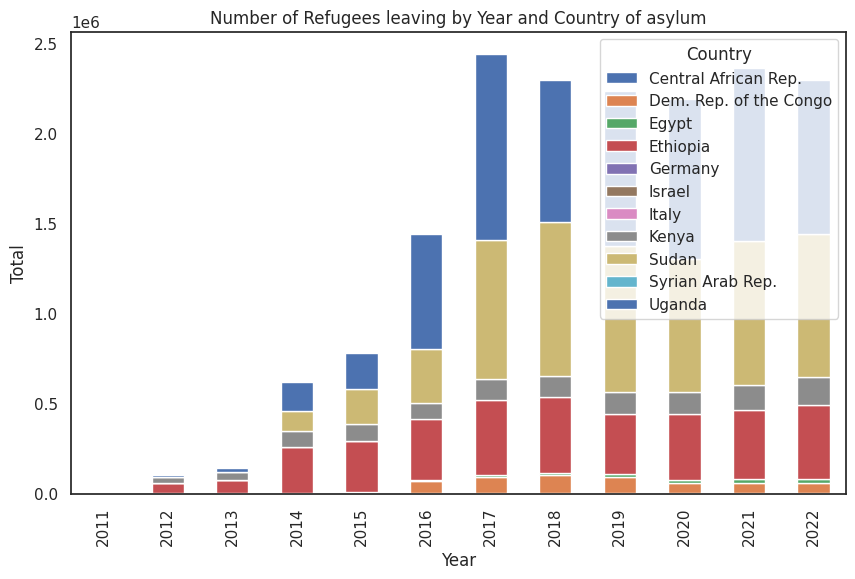

In [207]:
# Group and rank countries by year
moving_out['Rank'] = moving_out.groupby('Year')['Total'].rank(ascending=False)

# Filter for the top 3 countries
df_top3 = moving_out[moving_out['Rank'] <= 7]

# Pivot the data to create separate columns for each country
pivot_df = df_top3.pivot(index='Year', columns='Country of asylum', values='Total')

# Create the bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Number of Refugees leaving by Year and Country of asylum')
plt.legend(title='Country', loc='upper right')
plt.show()

In [ ]:
# Iterate through each year and create a donut chart
for year in df_grouped['Year']:
    year_data = df_grouped[df_grouped['Year'] == year].iloc[:, 1:-1]  # Exclude the "Total" column current year
    labels = year_data.columns
    sizes = year_data.values[0]

    # Create a donut chart
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), pctdistance=0.85)

    # Create a legend with labels
    ax.legend(wedges, labels, title="Asylum Types", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Draw a circle in the center to make it a donut chart
    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Asylum Seekers by Kind - {year}')
    plt.show()

### Correlation of people moving out of SS with food crisis

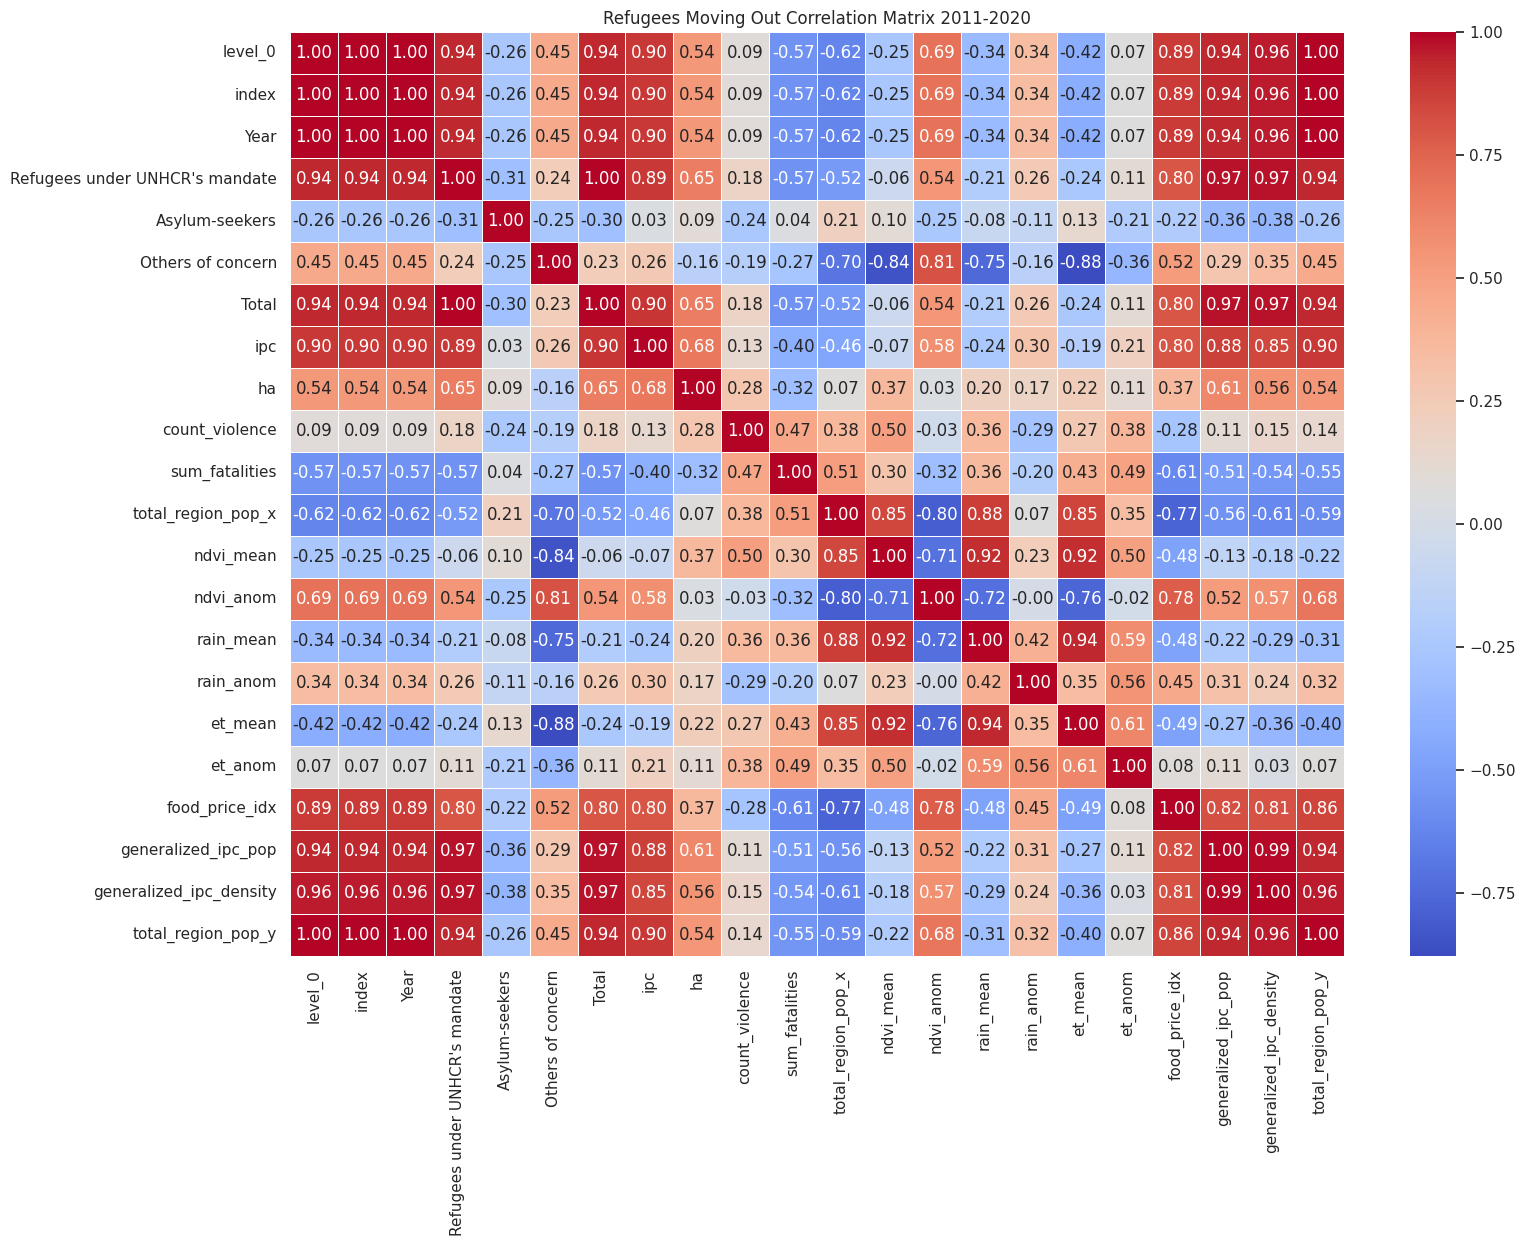

In [211]:
# renaming column and resetting index
ipc_country = ipc_country.rename(columns={"year": "Year"})
df_grouped.reset_index(inplace=True)

# Removing constant columns
df_grouped = df_grouped.drop("Stateless persons", axis=1)

# Filter for the years 2011 to 2020
years_to_include = list(range(2011, 2021))
df_grouped = df_grouped[df_grouped['Year'].isin(years_to_include)]

merged_moveout = pd.merge(df_grouped, ipc_country, on='Year')

# Calculate the correlation matrix
moveout_corr = merged_moveout.corr()

sns.set(style="white")

# # A function to plot the correlation matrix
def plot_correlation_matrix(corr_matrix, title):
    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(17, 12))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=.5, fmt=".2f")
    plt.title(title)
    plt.show()

plot_correlation_matrix(moveout_corr, "Refugees Moving Out Correlation Matrix 2011-2020")

## Internally displaced population (IDP)

In [17]:
# Run if you don't already have the internal_move.csv

# moving_out = pd.read_csv("data/moving_out.csv", on_bad_lines='skip')
# idp_df = moving_out[moving_out["Country of asylum (ISO)"] == "SSD"]
# idp_df.to_csv("data/internal_move.csv", index = False)

In [213]:
internal_df = pd.read_csv("data/internal_move.csv")

# Dropping redundant columns
internal_df = internal_df.drop(["Country of origin (ISO)", "Country of origin", "Country of asylum (ISO)", "Country of asylum", "Host Community", "Other people in need of international protection", "Refugees under UNHCR's mandate", "Asylum-seekers", "Stateless persons"], axis=1)

# Adding sum of all refugee like population
internal_df["Total"] = internal_df[["IDPs of concern to UNHCR", "Others of concern"]].sum(axis=1)

In [214]:
internal_df.head()

,Year,IDPs of concern to UNHCR,Others of concern,Total
0,2011,560161,0,560161
1,2012,345670,0,345670
2,2013,331097,0,331097
3,2014,1645392,0,1645392
4,2015,1790427,0,1790427


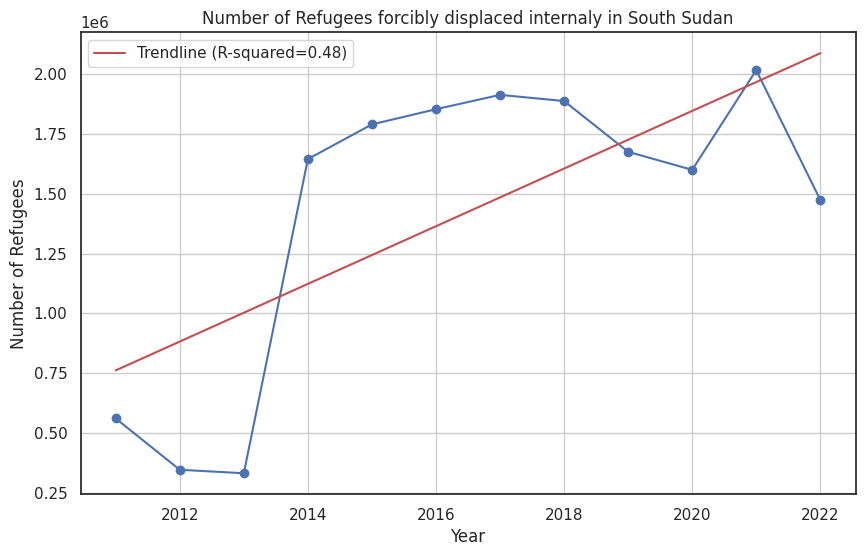

In [215]:
# Create a line chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(internal_df['Year'], internal_df['Total'], marker='o', linestyle='-')
plt.title('Number of Refugees forcibly displaced internaly in South Sudan')
plt.xlabel('Year')
plt.ylabel('Number of Refugees')
plt.grid(True)

# Fitting a linear regression model
slope, intercept, r_value, p_value, std_err = linregress(internal_df['Year'], internal_df['Total'])

# Create a trendline using the regression model
trendline = intercept + slope * internal_df['Year']

# Add the trendline to the chart as a red line
plt.plot(internal_df['Year'], trendline, 'r', label=f'Trendline (R-squared={r_value**2:.2f})')

# Add a legend to the chart
plt.legend()

# Show the plot
plt.show()

# New data source for Internal Displacements

Data is collected in rounds and is collected every 6 months. Some rounds are missing

In [5]:
# round_2 = pd.read_excel("internal_movements/round_2.xlsx")
# round_4 = pd.read_excel("internal_movements/round_4.xlsx")
# round_5 = pd.read_excel("internal_movements/round_5.xlsx")
# round_6 = pd.read_excel("internal_movements/round_6.xlsx")
# round_7 = pd.read_excel("internal_movements/round_7.xlsx")
# round_8 = pd.read_excel("internal_movements/round_8.xlsx")
# round_9 = pd.read_excel("internal_movements/round_9.xlsx")
# round_10 = pd.read_excel("internal_movements/round_10.xlsx")
# round_11 = pd.read_excel("internal_movements/round_11.xlsx")
# round_12 = pd.read_excel("internal_movements/round_12.xlsx")
# round_13 = pd.read_excel("internal_movements/round_13.xlsx")
# round_14 = pd.read_excel("internal_movements/round_14.xlsx")

In [33]:
asylum = pd.read_csv("data/2015_2023_asylum.csv")
asylum.head()

In [7]:
# Group by the 'region' column and sum the numeric columns
asylum = asylum.groupby(['region', 'year']).agg({
    'idp': 'sum', 'returnee': 'sum', 'total': 'sum'
}).reset_index()

asylum.head()

### Aggregating values to administrative regions

In [16]:
ipc_internal = ipc
ipc_internal = ipc_internal.drop(ipc_internal.columns[0], axis=1)

# Filter for the years 2015 to 2019
years_to_include = list(range(2015, 2020))
ipc_internal = ipc_internal[ipc_internal['year'].isin(years_to_include)]

# List of numeric columns
numeric_columns = [col for col in ipc_internal.columns if pd.api.types.is_numeric_dtype(ipc_internal[col])]

# Columns to remove
to_remove = ["year", "district_code", "centx", "centy", "year_month", "month", "area", "ipc", "pop", "normalized_population", "weighted_ipc_pop", "pop_density", "weighted_ipc_density"]

# Remove specified columns from numeric_columns
numeric_columns = [col for col in numeric_columns if col not in to_remove]

# Define a dictionary of aggregation functions
agg_funcs = {
    "ha": "sum",
    "count_violence": "sum",
    "sum_fatalities": "sum",
    "ndvi_mean": "median",
    "ndvi_anom": "median",
    "rain_mean": "median",
    "rain_anom": "median",
    "et_mean": "median",
    "et_anom": "median",
    "food_price_idx": "median",
    "cropland_pct": "median",
    "ruggedness_mean": "median",
    "pasture_pct": "median",
    "total_region_pop": "median",
    "generalized_ipc_pop": "median",
    "generalized_ipc_density": "median",
}

# Group and aggregate the columns
result = ipc_internal.groupby(['administrative_region', 'year'])[numeric_columns].agg(agg_funcs).reset_index()

# Change column name to later merge
result = result.rename(columns = {"administrative_region": "region"})

# Dropping columns "cropland_pct", "ruggedness_mean", "pasture_pct" bc they stay the same through the years
result = result.drop(["cropland_pct", "ruggedness_mean", "pasture_pct"], axis=1)

In [73]:
result.head()

,region,year,ha,count_violence,sum_fatalities,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,food_price_idx,total_region_pop,generalized_ipc_pop,generalized_ipc_density
0,Bahr El Ghazal,2015,1.0,65,439,0.543481,103.000300,13.311625,-0.005814,10.625935,0.363305,3.072672,3079776.0,2.077271,2.093805
1,Bahr El Ghazal,2016,6.0,52,172,0.532602,98.653825,12.415205,-0.003216,10.864320,-0.096672,8.309710,3451016.0,2.479470,2.359491
2,Bahr El Ghazal,2017,9.0,44,159,0.582081,103.656100,11.262440,-1.757922,14.346090,1.310745,31.592725,3822256.0,2.957717,2.934711
3,Bahr El Ghazal,2018,23.0,88,294,0.573009,102.705200,12.048460,0.027469,14.734960,1.304138,45.389400,4193492.0,3.027408,3.002200
4,Bahr El Ghazal,2019,12.0,19,71,0.599860,102.737800,12.725685,0.363146,18.602500,3.210733,69.751840,4564735.0,3.268389,3.245119


In [74]:
# Merge the two dataframes on 'year' and 'region'
merged_df = asylum.merge(result, on=["region", "year"])
merged_df.head()

,state_name,region,year,idp,returnee,total,ha,count_violence,sum_fatalities,ndvi_mean,ndvi_anom,rain_mean,rain_anom,et_mean,et_anom,food_price_idx,total_region_pop,generalized_ipc_pop,generalized_ipc_density
0,Central Equatoria,Equatoria,2015,26613,21232,47845,0.0,62,108,0.620708,101.64325,18.71972,-0.206225,20.401815,1.830840,2.752262,5353149.0,1.426627,1.440855
1,Eastern Equatoria,Equatoria,2015,17097,6243,23340,0.0,62,108,0.620708,101.64325,18.71972,-0.206225,20.401815,1.830840,2.752262,5353149.0,1.426627,1.440855
2,Western Equatoria,Equatoria,2015,13331,870,14201,0.0,62,108,0.620708,101.64325,18.71972,-0.206225,20.401815,1.830840,2.752262,5353149.0,1.426627,1.440855
3,Central Equatoria,Equatoria,2016,108780,1321,110101,1.0,113,304,0.598490,100.37450,17.16670,-1.176392,19.658615,-0.432708,8.346504,5123228.0,2.432189,2.358150
4,Eastern Equatoria,Equatoria,2016,27314,6798,34112,1.0,113,304,0.598490,100.37450,17.16670,-1.176392,19.658615,-0.432708,8.346504,5123228.0,2.432189,2.358150


In [19]:
# Group the dataframe by region
grouped = merged_df.groupby('region')

corr_matrices = {}

# Iterate through groups and calculate correlations
for name, group in grouped:
    # Select numeric columns only
    numeric_group = group.select_dtypes(include='number')

    # Calculate the correlation matrix
    corr_matrix = numeric_group.corr()

    # Store the correlation matrix in the dictionary
    corr_matrices[name] = corr_matrix

# Correlation matrices for each region
bahr_corr = corr_matrices["Bahr El Ghazal"]
equa_corr = corr_matrices["Equatoria"]
nile_corr = corr_matrices["Greater Upper Nile"]

### Plotting

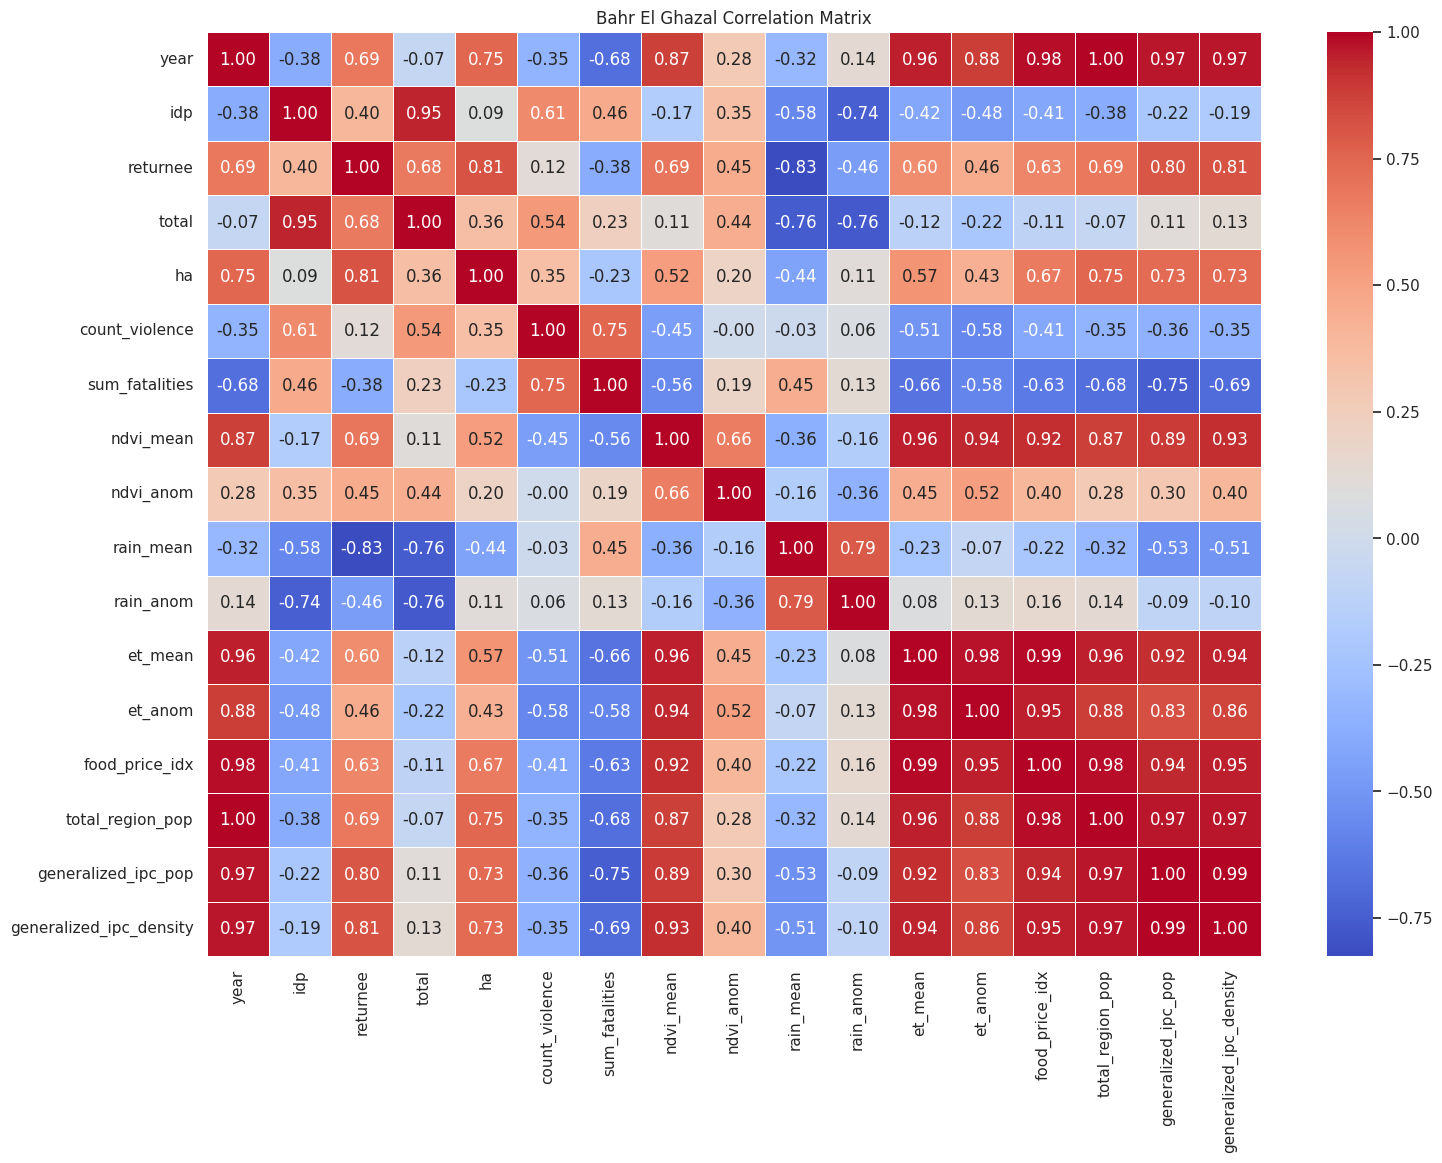

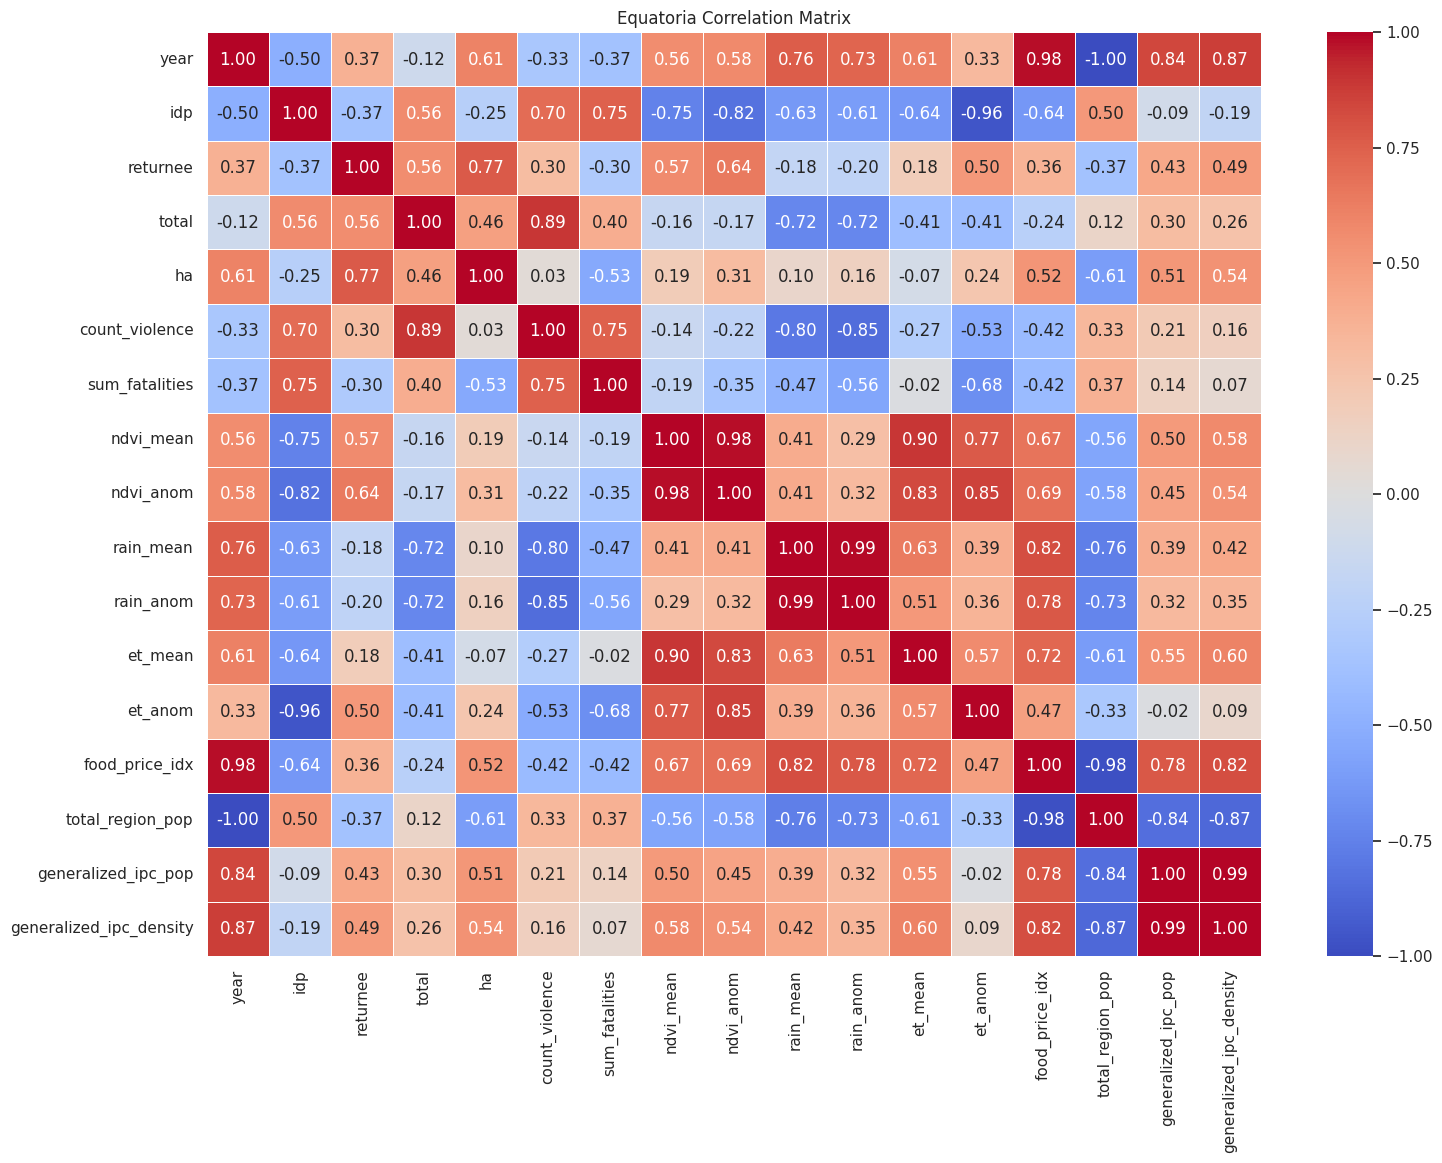

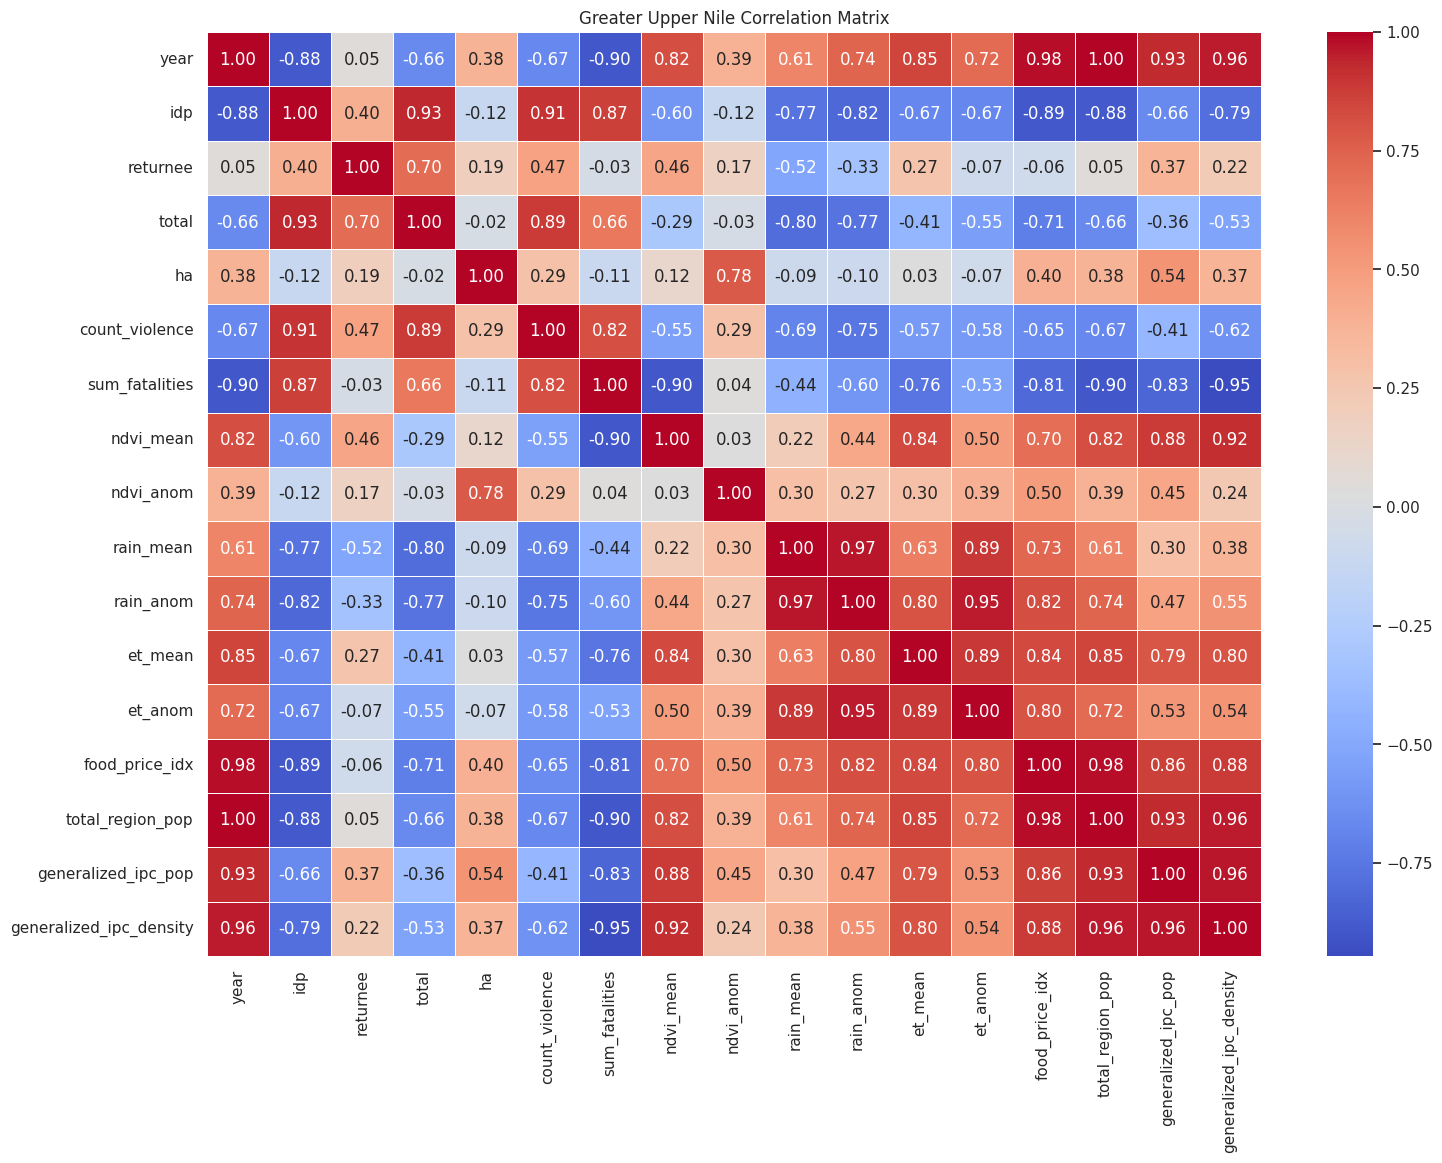

In [77]:
# Plot the correlation matrices for each region
plot_correlation_matrix(bahr_corr, "Bahr El Ghazal Correlation Matrix")
plot_correlation_matrix(equa_corr, "Equatoria Correlation Matrix")
plot_correlation_matrix(nile_corr, "Greater Upper Nile Correlation Matrix")